import stuff here

In [1]:
from pyomo.environ import *
from itertools import product
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import sys
# append a new directory to sys.path
sys.path.append("C:\\Users\\Tassili\\Documents\\GitHub\\FSC-optimization")
from QCLP_formulation import *
import networkx as nx
import os
os.environ['NEOS_EMAIL'] = 'malikbf5@gmail.com' 


# General two-armed Bernoulli Bandits

  Credits: Andrea Mazzolini, Alberto Pezzotta 

In the standard "two-armed Bernoulli Bandits" we can pull one of the two arms of a bandit (slot-machine) $a\in \lbrace 1,2 \rbrace$. Both the arms provide a Bernoulli-distributed reward: $r = 1$ with probability $q_i$, $r = 0$ with $1-q_i$, where $i \in \lbrace 1,2 \rbrace$.

<div>
<img src="Bandits.PNG" width="200">
</div>

There is a whole 2D space of possible bandits.
Each point correspond to a single state, that is a single realization of the two-bandits above.

<div>
<img src="BeliefSpace.PNG" width="200">
</div>
Solving each problem is trivial: we just use the arm with larger success probability.

In our case we'll consider two possible states to be in (state A and B) where each state is characterized by its winning probabilities for each arm which we'll denote as $\theta$, so state A is characterized by ($\theta_{A,1}, \theta_{A,2}$) and for B ($\theta_{B,1}, \theta_{B,2}$)

By choosing random values of $\theta$ for each arm we get the following states:

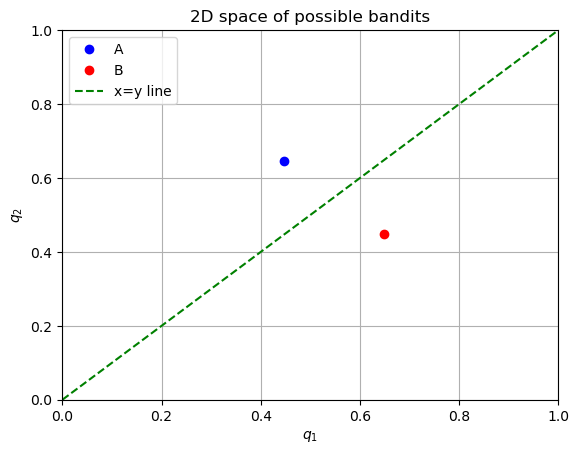

In [17]:
# Define gap you want
gap = 0.2
gamma = 0.9
x1 = np.random.uniform(0, 1- gap)
y1 = x1 + gap
x2 = np.random.uniform(gap, 1)
y2 = x2 - gap
# Plot the points
plt.plot(x1, y1, 'bo', label='A')
plt.plot(x2, y2, 'ro', label='B')
plt.plot([0, 1], [0, 1], 'g--', label='x=y line')

# Set plot limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add grid
plt.grid(True)

# Add labels and legend
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
plt.title('2D space of possible bandits')
plt.legend()

In [ ]:
# create two figures for state A and B



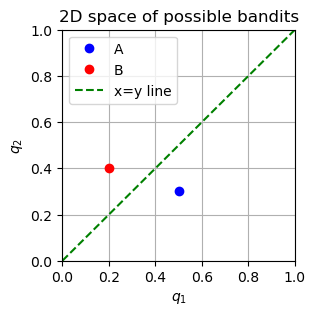

In [2]:
# Define the coordinates of the two points
# point1 = np.random.uniform(0, 1, 2)
# point2 = np.random.uniform(0, 1, 2)
point1 = [0.5, 0.3]
point2 = [0.2, 0.4]
# Extract x and y coordinates of each point
x1, y1 = point1
x2, y2 = point2

# Plot the points
plt.plot(x1, y1, 'bo', label='A')
plt.plot(x2, y2, 'ro', label='B')
plt.plot([0, 1], [0, 1], 'g--', label='x=y line')

# Set plot limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add grid
plt.grid(True)

# Add labels and legend
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
plt.title('2D space of possible bandits')
plt.legend()

# set plot size
plt.gcf().set_size_inches(3, 3)
# Show plot
plt.show()


In [50]:
#Define POMDP 

num_states = 2 # Number of states
num_actions = 2 # Number of actions
num_observations = 2 # Number of observations

s = list(range(num_states))  # state A & B
a = list(range(num_actions)) # pull arm 1 or pull arm 2
o = list(range(num_observations))  # recieve reward 1 or 0

# P(s'|s,a) in this case equals 1 when s' = s and 0 otherwise
state_transition_model = np.zeros((num_states, num_actions, num_states)) 
for state, sprime, action in product(s,s,a):
    if state ==  sprime:
        state_transition_model[sprime, action, state] = 1

# R(s,a), since the reward is stochastic we take instead the average reward for each arm and state
reward_model = np.zeros((num_states, num_actions))
# state A
reward_model[0, 0], reward_model[0, 1] = x1, y1
# state B
reward_model[1, 0], reward_model[1, 1] = x2, y2

def bernoulliprob(p,y):
    return p**y * (1-p)**(1-y)

# O(o|s',a) the probability of observing reward o in state s' after taking action a
observation_model = np.zeros((num_states, num_actions, num_observations)) 
# state A
# if action 0 is taken
observation_model[0, 0, 1], observation_model[0, 0, 0] = x1, 1 - x1
# if action 1 is taken
observation_model[0, 1, 1], observation_model[0, 1, 0] = y1, 1 - y1
# state B
# if action 0 is taken
observation_model[1, 0, 1], observation_model[1, 0, 0] = x2, 1 - x2
# if action 1 is taken
observation_model[1, 1, 1], observation_model[1, 1, 0] = y2, 1 - y2

Visualizing POMDP parameter values

In [51]:
def statename(state):
    return 'A' if state == 0 else 'B'
state_transition_model_dict = {
    str((statename(sprime),action +1,statename(state))): state_transition_model[sprime,action,state]
    for sprime,action,state in product(s,a,s)
}
state_transition_model_df = pd.DataFrame(state_transition_model_dict, index=['Transition probability']) 
state_transition_model_df = state_transition_model_df.rename_axis("(s',a,s)", axis="columns")
state_transition_model_df

"(s',a,s)","('A', 1, 'A')","('A', 1, 'B')","('A', 2, 'A')","('A', 2, 'B')","('B', 1, 'A')","('B', 1, 'B')","('B', 2, 'A')","('B', 2, 'B')"
Transition probability,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [52]:
rewarddf = pd.DataFrame(reward_model, index=['A', 'B'], columns=['Arm 1', 'Arm 2'])
rewarddf.rename_axis("state", axis="index")

,Arm 1,Arm 2
state,,
A,0.4,0.6
B,0.6,0.4


In [53]:
observation_model_dict = {
    (str((statename(sprime),action +1,observation))): observation_model[sprime,action,observation]
    for sprime,action,observation in product(s,a,o) }
observation_model_df = pd.DataFrame(observation_model_dict, index=['Observation probability'])
observation_model_df.rename_axis("(s',a,o)", axis="index")

,"('A', 1, 0)","('A', 1, 1)","('A', 2, 0)","('A', 2, 1)","('B', 1, 0)","('B', 1, 1)","('B', 2, 0)","('B', 2, 1)"
"(s',a,o)",,,,,,,,
Observation probability,0.6,0.4,0.4,0.6,0.4,0.6,0.6,0.4


# QCLP formulation
<div>
<img src="QCLP formulation.PNG" width="600">
</div>

Where:  
The variable $x(q', a, q, o)$ represents $P(q', a|q, o)$  
The variable $y(q, s)$ represents $V(q, s)$  
$q_0$ is the initial controller node  
$o_k$ is an arbitrary fixed observation  

Note that $P(q', a|q, o)= P(q'|q, a, o) \pi(a|q)$ 

And $\sum{q'} P(q', a|q, o) = \pi(a|q)$

Parameters <br>
$\gamma$: discount factor <br>
$b_0(s)$: initial distribution of states <br>
$\rho(q)$: initial distribution over nodes in objective function, either $\rho(q_0) = 1$ or uniform

In [54]:
# discount factor
gamma = 0.9

# b_0(s)
b0 = np.ones((num_states)) / num_states # uniform initial distribution over states

# distribution over nodes
# this fixes the objective function to maximize over y(q_0,s)
obj = "first node" 
# this fixes the objective function to maximize over all y(q,s) with uniform distribution
# obj = "all nodes" 

## Generating instances 
where the x variables are restarted randomly to cover more of the search space

In [55]:
number_instances = 1
controller_size_list = [2,3,4]
ssol = opt_instances(controller_size_list, number_instances,
                     num_states, num_actions, num_observations, 
                     b0, gamma, state_transition_model, reward_model, 
                     observation_model, obj = obj)
ssol["dataframe"]

,max obj,mean obj,mean value,mean value for nodes V(q),mean value for states V(s)
controller size,,,,,
2,5.180000,5.180000,5.180,"[5.18, 5.18]","[5.18, 5.18]"
3,5.249321,5.249321,5.221,"[5.25, 5.21, 5.21]","[5.14, 5.31]"
4,5.305529,5.305529,5.270,"[5.31, 5.3, 5.25, 5.22]","[5.2, 5.34]"


In [56]:
ssol[2][0]

{'model': <pyomo.core.base.PyomoModel.ConcreteModel at 0x1b6bf80c730>,
 'value df': (q,s)  (0, 0) (0, 1) (1, 0) (1, 1)  objective funct  mean value  \
 V(q,s)   5.08   5.28   5.28   5.08             5.18        5.18   
 
 (q,s)  value for nodes V(q) value for states V(s)  
 V(q,s)         [5.18, 5.18]          [5.18, 5.18]  ,
 'action selection df': (a,q)    (0, 0) (0, 1) (1, 0) (1, 1)
 P(a | q)    1.0    0.0    0.0    1.0,
 'node transition df': (q',a,q,o)      (0, 0, 0, 0) (0, 0, 0, 1) (0, 0, 1, 0) (0, 0, 1, 1)  \
 P(q' | q, a, o)          0.0          1.0          0.0          1.0   
 P(q',a | q,o)            0.0          1.0          0.0          0.0   
 
 (q',a,q,o)      (0, 1, 0, 0) (0, 1, 0, 1) (0, 1, 1, 0) (0, 1, 1, 1)  \
 P(q' | q, a, o)          0.0          0.0          1.0          0.0   
 P(q',a | q,o)            0.0          0.0          1.0          0.0   
 
 (q',a,q,o)      (1, 0, 0, 0) (1, 0, 0, 1) (1, 0, 1, 0) (1, 0, 1, 1)  \
 P(q' | q, a, o)          1.0          0.0